In [1]:
import json
import yaml
import os
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML
config = yaml.safe_load(open("/gscratch/balazinska/enhaoz/VOCAL-UDF/configs/config.yaml", "r"))

import re
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

CB_color_cycle = ['#ff7f00', '#4daf4a', '#377eb8',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [4]:
def plot():
    datasets = ["clevrer", "cityflow", "charades"]
    dataset_to_config = {
        "clevrer": {
            "dataset_title": "CLEVRER",
            "query_class_names": [
                "3_new_udfs_labels",
            ],
            "question_ids": list(range(30)),
            "run_ids": list(range(3)),
            "num_new_udfs": [0, 1, 2, 3],
            "vocal_udf_config_name": "ninterp=10-nparams=5-kwargs=True-pixels=True-pretrained_models=False-ntrain_distill=100-nselection_samples=500-selection=both-labels=user-budget=20-llm_method=gpt4v"
        },
        "cityflow": {
            "dataset_title": "CityFlow-NL",
            "query_class_names": [
                "unavailable_pred=1-unavailable_attr_pred=1-npred=1-nattr_pred=2-nvars=3-depth=3-max_duration=15-min_npos=74-max_npos=737",
                "unavailable_pred=1-unavailable_attr_pred=1-npred=2-nattr_pred=2-nvars=3-depth=3-max_duration=15-min_npos=74-max_npos=737"
            ],
            "question_ids": list(range(15)),
            "run_ids": list(range(3)),
            "num_new_udfs": [0, 1, 2],
            "vocal_udf_config_name": "ninterp=10-nparams=5-kwargs=True-pixels=False-pretrained_models=False-ntrain_distill=500-nselection_samples=500-selection=both-labels=user-budget=50-llm_method=gpt4v"
        },
        "charades": {
            "dataset_title": "Charades",
            "query_class_names": [
                "unavailable=2-npred=4-nobj_pred=1-nvars=3-depth=2",
                "unavailable=2-npred=4-nobj_pred=1-nvars=2-depth=2",
                "unavailable=2-npred=3-nobj_pred=1-nvars=2-depth=2"
            ],
            "question_ids": list(range(10)),
            "run_ids": list(range(3)),
            "num_new_udfs": [0, 1, 2],
            "vocal_udf_config_name": "ninterp=10-nparams=5-kwargs=True-pixels=False-pretrained_models=False-ntrain_distill=500-nselection_samples=500-selection=both-labels=user-budget=50-llm_method=gpt4v"
        },
    }
    # Define LLM models, tasks, number of new UDFs, and hatch patterns
    llm_models = ['visprog', 'equi-vocal', 'vocal-udf']
    llm_model_labels = ['VisProg', 'EQUI-VOCAL', 'SEVDA']

    hatch_patterns = ['///', '\\\\\\', '...', 'xxx', '***', '+++', '|||', '---', 'ooo']
    handles_f1 = []

    # Create a figure and axis for the boxplot
    fig, axes = plt.subplots(3, 3, figsize=(7, 4.5), sharey=True, width_ratios=[4, 3, 3])
    # fig_precision, axes_precision = plt.subplots(1, 3, figsize=(7, 2), sharey=True, width_ratios=[3, 2, 2])
    # fig_recall, axes_recall = plt.subplots(1, 3, figsize=(7, 2), sharey=True, width_ratios=[3, 2, 2])
    for did, dataset in enumerate(datasets):
        dataset_title = dataset_to_config[dataset]["dataset_title"]
        query_class_names = dataset_to_config[dataset]["query_class_names"]
        question_ids = dataset_to_config[dataset]["question_ids"]
        run_ids = dataset_to_config[dataset]["run_ids"]
        num_new_udfs = dataset_to_config[dataset]["num_new_udfs"]
        vocal_udf_config_name = dataset_to_config[dataset]["vocal_udf_config_name"]

        # Iterate through LLM models
        for i, llm_model in enumerate(llm_models):
            print(f"######## {llm_model} ########")
            f1_data = []
            precision_data = []
            recall_data = []

            # Iterate through tasks
            for task_id in num_new_udfs:
                task = f"{task_id}_new_udfs"
                f1_list = []
                precision_list = []
                recall_list = []
                failed_list = []

                # Iterate through runs and questions
                if llm_model in ["equi-vocal"]:
                    for query_class_name in query_class_names:
                        for run_id in run_ids:
                            for question_id in question_ids:
                                try:
                                    with open(os.path.join(config['log_dir'], "query_execution_precision_recall", dataset, query_class_name, f"num_missing_udfs={task_id}", llm_model, f"qid={question_id}-run={run_id}.log"), "r") as f:
                                        lines = f.readlines()
                                    f1_score = -1
                                    for l_idx, line in enumerate(lines):
                                        if "F1 score:" in line:
                                            f1_score_pattern = r"F1 score: ([0-9.]+)"
                                            match = re.search(f1_score_pattern, line)
                                            f1_score = float(match.group(1))
                                            precision = float(re.search(r"Precision: ([0-9.]+)", lines[l_idx+1]).group(1))
                                            recall = float(re.search(r"Recall: ([0-9.]+)", lines[l_idx+2]).group(1))
                                            failed_list.append(0)
                                            break
                                    if f1_score == -1:
                                        print(f"failed task: qid={question_id}-run={run_id}")
                                        failed_list.append(1)
                                        f1_score = 0
                                        precision = 0
                                        recall = 0
                                    f1_list.append(f1_score)
                                    precision_list.append(precision)
                                    recall_list.append(recall)
                                except Exception as e:
                                    print(e)
                                    continue

                elif llm_model in ['vocal-udf']:
                    for query_class_name in query_class_names:
                        for run_id in run_ids:
                            for question_id in question_ids:
                                try:
                                    with open(os.path.join(config['log_dir'], "query_execution_precision_recall", dataset, query_class_name, f"num_missing_udfs={task_id}", vocal_udf_config_name, f"qid={question_id}-run={run_id}.log"), "r") as f:
                                        lines = f.readlines()
                                    f1_score = -1
                                    for l_idx, line in enumerate(lines):
                                        if "F1 score:" in line:
                                            f1_score_pattern = r"F1 score: ([0-9.]+)"
                                            match = re.search(f1_score_pattern, line)
                                            f1_score = float(match.group(1))
                                            precision = float(re.search(r"Precision: ([0-9.]+)", lines[l_idx+1]).group(1))
                                            recall = float(re.search(r"Recall: ([0-9.]+)", lines[l_idx+2]).group(1))
                                            failed_list.append(0)
                                            break
                                    if f1_score == -1:
                                        print(f"failed task: qid={question_id}-run={run_id}")
                                        failed_list.append(1)
                                        f1_score = 0
                                        precision = 0
                                        recall = 0
                                    f1_list.append(f1_score)
                                    precision_list.append(precision)
                                    recall_list.append(recall)
                                except Exception as e:
                                    print(e)
                                    continue
                else:
                    for query_class_name in query_class_names:
                        for run_id in run_ids:
                            for question_id in question_ids:
                                try:
                                    with open(os.path.join(config['log_dir'], "query_execution", dataset, query_class_name, f"num_missing_udfs={task_id}", "visprog-llm=gpt-4o", f"qid={question_id}-run={run_id}.log"), "r") as f:
                                        lines = f.readlines()
                                    f1_score = -1
                                    for l_idx, line in enumerate(lines):
                                        if "F1: " in line:
                                            f1_score_pattern = r"F1: ([0-9.]+)"
                                            match = re.search(f1_score_pattern, line)
                                            f1_score = float(match.group(1))
                                            precision = float(re.search(r"Precision: ([0-9.]+)", lines[l_idx+1]).group(1))
                                            recall = float(re.search(r"Recall: ([0-9.]+)", lines[l_idx+2]).group(1))
                                            failed_list.append(0)
                                            break
                                    if f1_score == -1:
                                        print(f"failed task: qid={question_id}-run={run_id}")
                                        failed_list.append(1)
                                        f1_score = 0
                                        precision = 0
                                        recall = 0
                                    f1_list.append(f1_score)
                                    precision_list.append(precision)
                                    recall_list.append(recall)
                                except Exception as e:
                                    print(e)
                                    continue

                f1_data.append(f1_list)
                precision_data.append(precision_list)
                recall_data.append(recall_list)

                print(f"task_{task}_mean_f1: {np.mean(f1_list)}")
                print(f"task_{task}_mean_precision: {np.mean(precision_list)}")
                print(f"task_{task}_mean_recall: {np.mean(recall_list)}")
                print(f"task_{task}_prob_failures: {np.mean(failed_list)}")
                print()

            # Create a grouped boxplot for F1 scores
            bp_f1 = axes[0][did].boxplot(f1_data,
                            positions=np.array(range(len(f1_data))) * (len(llm_models) + 1) + i,
                            sym='.',
                            widths=1,
                            showfliers=False,
                            patch_artist=True,
                            boxprops=dict(facecolor=CB_color_cycle[i], hatch=hatch_patterns[i]),
                            medianprops=dict(color='black'))
            axes[1][did].boxplot(precision_data,
                            positions=np.array(range(len(precision_data))) * (len(llm_models) + 1) + i,
                            sym='.',
                            widths=1,
                            showfliers=False,
                            patch_artist=True,
                            boxprops=dict(facecolor=CB_color_cycle[i], hatch=hatch_patterns[i]),
                            medianprops=dict(color='black'))
            axes[2][did].boxplot(recall_data,
                            positions=np.array(range(len(recall_data))) * (len(llm_models) + 1) + i,
                            sym='.',
                            widths=1,
                            showfliers=False,
                            patch_artist=True,
                            boxprops=dict(facecolor=CB_color_cycle[i], hatch=hatch_patterns[i]),
                            medianprops=dict(color='black'))
            handles_f1.append(bp_f1["boxes"][0])

        # Customize the plot labels and legend
        # ax.set_title(f"question_ids: {question_ids}")
        ylabels = ["F1 Score", "Precision", "Recall"]
        for yid, ylabel in enumerate(ylabels):
            axes[yid][did].set(xlabel="# missing UDFs")
            axes[yid][did].set_ylim(bottom=0, top=1.05)
            if yid == 0:
                axes[yid][0].set_ylabel(ylabel)
            else:
                axes[yid][0].set_ylabel(ylabel, color="blue")

            axes[yid][did].set_xlim(left=-1, right=len(num_new_udfs) * (len(llm_models)+1) - 1)
            axes[yid][did].set_xticks(np.arange(len(llm_models) / 2 - 0.5, len(num_new_udfs) * len(llm_models) + len(llm_models) / 2 + 0.5, len(llm_models) + 1))
            axes[yid][did].set_xticklabels(num_new_udfs)
            axes[0][did].set_title(f"{dataset_title}", fontsize=10)
            if yid > 0:
                axes[yid][did].tick_params(axis='x', colors='blue')
                axes[yid][did].tick_params(axis='y', colors='blue')
                axes[yid][did].spines['bottom'].set_color('blue')
                axes[yid][did].spines['top'].set_color('blue')
                axes[yid][did].spines['left'].set_color('blue')
                axes[yid][did].spines['right'].set_color('blue')


    # Only display outer axes
    for ax in axes.flat:
        ax.label_outer()

    fig.tight_layout()
    fig.savefig(f"figures/eval.pdf", bbox_inches='tight')

    legendFig = plt.figure("Legend plot", figsize=(8, 1))
    legendFig.legend(handles_f1, llm_model_labels, loc='center', ncol=3, prop={"size": 10}, fancybox=True, shadow=False)
    legendFig.savefig('figures/end_to_end_legend.pdf', bbox_inches='tight')
    plt.gca().set_axis_off()
    plt.show()

######## visprog ########
task_0_new_udfs_mean_f1: 0.9955081186121507
task_0_new_udfs_mean_precision: 0.9958552328331987
task_0_new_udfs_mean_recall: 0.9953767442743839
task_0_new_udfs_prob_failures: 0.0

task_1_new_udfs_mean_f1: 0.6115581477435994
task_1_new_udfs_mean_precision: 0.5586017913920556
task_1_new_udfs_mean_recall: 0.7759195964903679
task_1_new_udfs_prob_failures: 0.0

task_2_new_udfs_mean_f1: 0.33316000518351646
task_2_new_udfs_mean_precision: 0.2910951209229123
task_2_new_udfs_mean_recall: 0.5450104133358245
task_2_new_udfs_prob_failures: 0.0

task_3_new_udfs_mean_f1: 0.189938648961312
task_3_new_udfs_mean_precision: 0.1404452398508873
task_3_new_udfs_mean_recall: 0.44699063250519644
task_3_new_udfs_prob_failures: 0.0

######## equi-vocal ########
failed task: qid=15-run=2
task_0_new_udfs_mean_f1: 0.988479309416295
task_0_new_udfs_mean_precision: 0.9882066614014238
task_0_new_udfs_mean_recall: 0.9887538271348191
task_0_new_udfs_prob_failures: 0.011111111111111112

task_1_

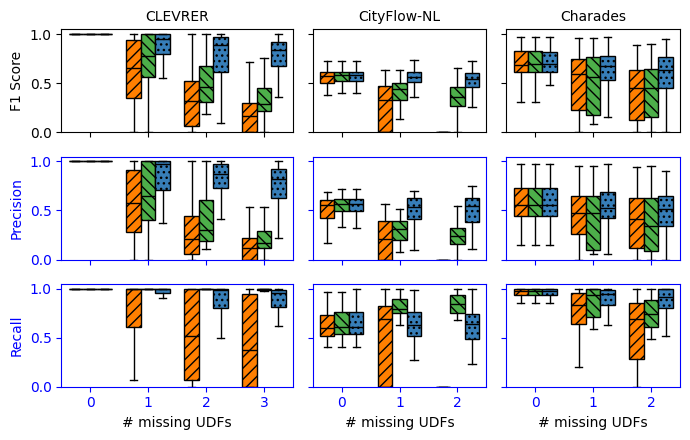

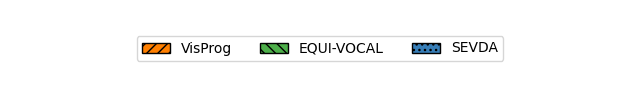

In [5]:
plot()